In [6]:
!pip install matminer

Dataset shape: (1306, 6)
      formula a_1 b_1 a_2 b_2  gap gllbsc
0  AgNbLaAlO6  Ag  Nb  La  Al    4.164543
1  AgNbLaGaO6  Ag  Nb  La  Ga    4.454629
2  AgNbLaInO6  Ag  Nb  La  In    4.192522
3  AgNbMgTiO6  Ag  Nb  Mg  Ti    3.963857
4  AgNbSnTiO6  Ag  Nb  Sn  Ti    2.881239
5   AgNbYAlO6  Ag  Nb   Y  Al    3.958215
6  AgTaAgNbO6  Ag  Ta  Ag  Nb    3.367340
7  AgTaBaSnO6  Ag  Ta  Ba  Sn    4.115528
8  AgTaBaTiO6  Ag  Ta  Ba  Ti    3.651875
9  AgTaCaGeO6  Ag  Ta  Ca  Ge    4.596742
Removing subgroup with a_1 = Ag
Mean Imputation -> R²: 0.575, RMSE: 1.019
KNN Imputation -> R²: 0.582, RMSE: 1.011


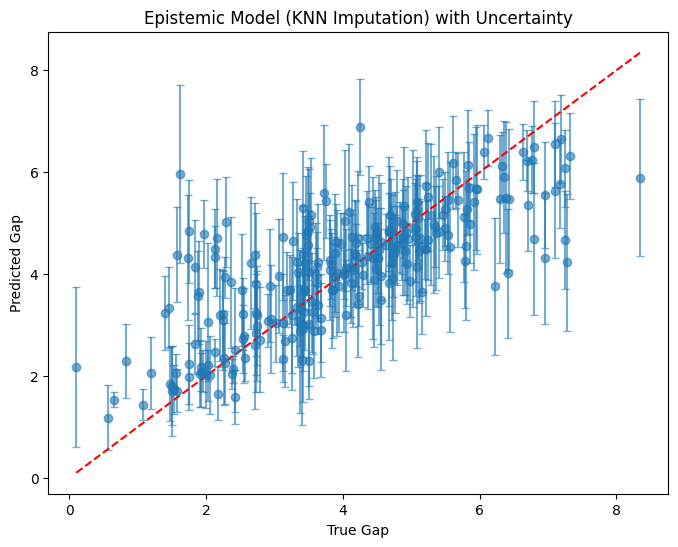

Epistemic Conformal 95% Coverage: 0.929


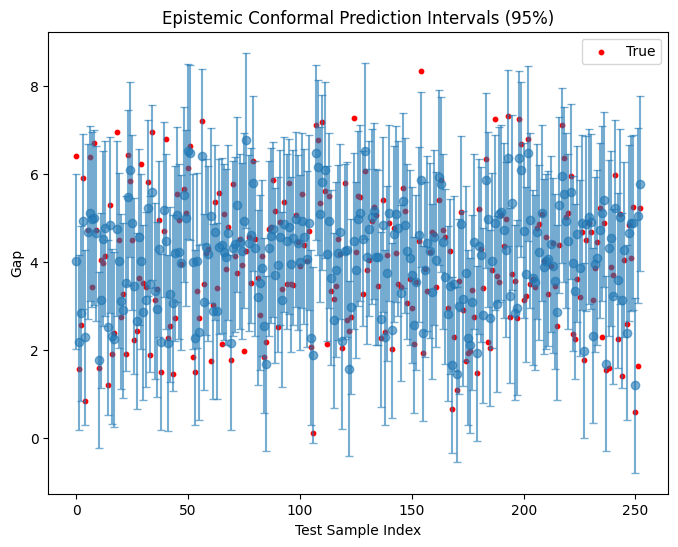

After Active Learning -> R²: 0.670, RMSE: 0.898


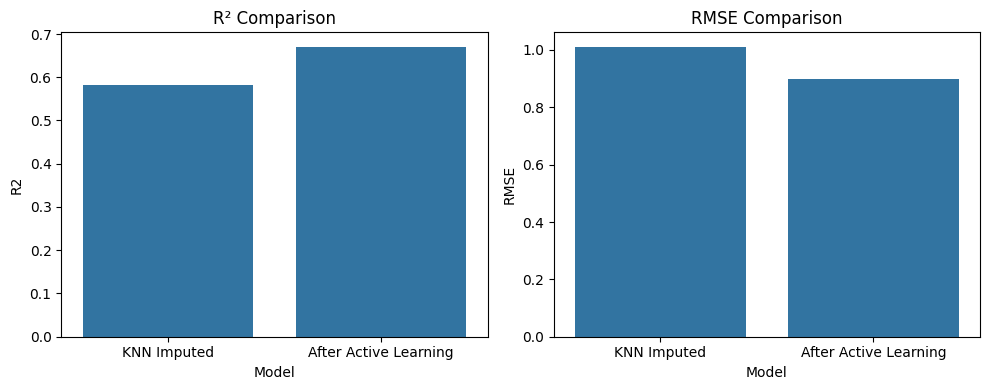

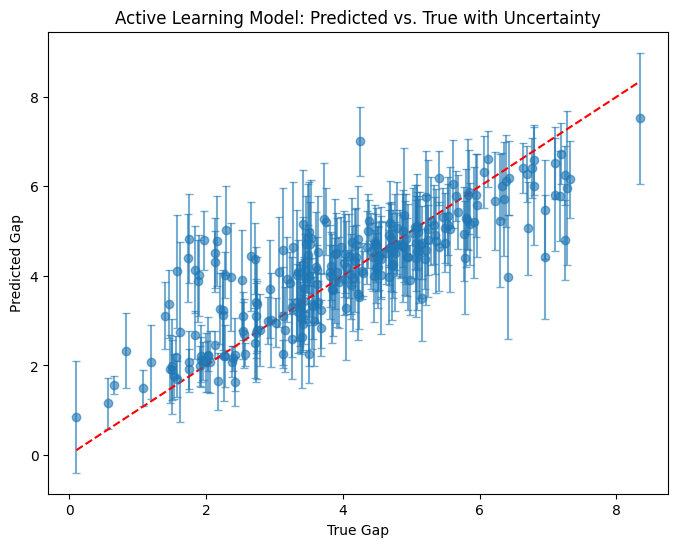

In [7]:
# %% [markdown]
"""
# Notebook 2: Handling Epistemic Uncertainty (Missing Data & Data Imputation)
This notebook simulates epistemic uncertainty in the Double Perovskites Gap dataset by:
- Removing a subgroup from training to simulate knowledge gaps.
- Introducing missing features (20% missing) and imputing them with mean and KNN.
- Training RandomForest regressors on these datasets.
- Evaluating performance (R², RMSE) and ensemble-based uncertainty.
- Computing conformal prediction intervals and visualizing prediction set sizes.
- Using active learning (adding high-uncertainty samples) to reduce epistemic uncertainty.
"""
# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import r2_score, mean_squared_error
from matminer.datasets import load_dataset

# Load dataset
df = load_dataset("double_perovskites_gap", download_if_missing=True)
print("Dataset shape:", df.shape)
print(df.head(10))

# %% [code]
# Cell 2: Removing a Subgroup from Training (simulate missing knowledge)
# Remove a subgroup based on an elemental label in 'a_1'
group_to_remove = df["a_1"].unique()[0]
print("Removing subgroup with a_1 =", group_to_remove)
df_epi = df[df["a_1"] != group_to_remove].reset_index(drop=True)

# Preprocess: drop 'formula' and one-hot encode
df_epi = df_epi.drop(columns=["formula"])
df_epi = pd.get_dummies(df_epi, columns=["a_1", "b_1", "a_2", "b_2"])
X_epi = df_epi.drop(columns=["gap gllbsc"]).values
y_epi = df_epi["gap gllbsc"].values

# Split & scale (training only on available subgroup)
X_train_epi, X_test_epi, y_train_epi, y_test_epi = train_test_split(X_epi, y_epi, test_size=0.2, random_state=42)
scaler_epi = StandardScaler()
X_train_epi = scaler_epi.fit_transform(X_train_epi)
X_test_epi = scaler_epi.transform(X_test_epi)

# %% [code]
# Cell 3: Imputing Missing Features (simulate 20% missing)
def introduce_missing(X, missing_rate=0.2, random_state=42):
    np.random.seed(random_state)
    X_miss = X.copy()
    mask = np.random.rand(*X_miss.shape) < missing_rate
    X_miss[mask] = np.nan
    return X_miss

X_train_miss = introduce_missing(X_train_epi, 0.2)
X_test_miss  = introduce_missing(X_test_epi, 0.2)

# Impute with Mean & KNN
imputer_mean = SimpleImputer(strategy="mean")
imputer_knn = KNNImputer(n_neighbors=5)
X_train_mean = imputer_mean.fit_transform(X_train_miss)
X_test_mean = imputer_mean.transform(X_test_miss)
X_train_knn = imputer_knn.fit_transform(X_train_miss)
X_test_knn = imputer_knn.transform(X_test_miss)

# %% [code]
# Cell 4: Model Performance After Imputation
models = {}
for imp, Xtr, Xte in zip(["Mean", "KNN"], [X_train_mean, X_train_knn], [X_test_mean, X_test_knn]):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(Xtr, y_train_epi)
    y_pred = rf.predict(Xte)
    r2_val = r2_score(y_test_epi, y_pred)
    rmse_val = np.sqrt(mean_squared_error(y_test_epi, y_pred))
    models[imp] = {"model": rf, "pred": y_pred, "r2": r2_val, "rmse": rmse_val, "X_test": Xte}
    print(f"{imp} Imputation -> R²: {r2_val:.3f}, RMSE: {rmse_val:.3f}")

# %% [code]
# Cell 5: Visualizing Epistemic Uncertainty via Ensemble Variance
def ensemble_uncertainty(model, X):
    preds = np.array([est.predict(X) for est in model.estimators_])
    return preds.mean(axis=0), preds.std(axis=0)

# For KNN imputed model
mean_knn, std_knn = ensemble_uncertainty(models["KNN"]["model"], models["KNN"]["X_test"])
plt.figure(figsize=(8,6))
plt.errorbar(y_test_epi, mean_knn, yerr=std_knn, fmt='o', alpha=0.6, capsize=3)
plt.plot([y_test_epi.min(), y_test_epi.max()], [y_test_epi.min(), y_test_epi.max()], 'r--')
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.title("Epistemic Model (KNN Imputation) with Uncertainty")
plt.show()

# %% [code]
# Cell 6: Conformal Prediction for Epistemic Uncertainty
# Split a calibration set from training (using KNN imputed training)
X_train_cal_epi, X_cal_epi, y_train_cal_epi, y_cal_epi = train_test_split(X_train_knn, y_train_epi, test_size=0.2, random_state=42)
rf_cal_epi = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cal_epi.fit(X_train_cal_epi, y_train_cal_epi)
y_cal_pred_epi = rf_cal_epi.predict(X_cal_epi)
resid_epi = np.abs(y_cal_epi - y_cal_pred_epi)
q_epi = np.quantile(resid_epi, 0.95)
y_test_pred_epi = rf_cal_epi.predict(X_test_knn)
lower_epi = y_test_pred_epi - q_epi
upper_epi = y_test_pred_epi + q_epi
coverage_epi = np.mean((y_test_epi >= lower_epi) & (y_test_epi <= upper_epi))
print(f"Epistemic Conformal 95% Coverage: {coverage_epi:.3f}")

plt.figure(figsize=(8,6))
plt.errorbar(np.arange(len(y_test_epi)), y_test_pred_epi, yerr=q_epi, fmt='o', alpha=0.6, capsize=3)
plt.scatter(np.arange(len(y_test_epi)), y_test_epi, color='red', s=10, label="True")
plt.xlabel("Test Sample Index")
plt.ylabel("Gap")
plt.title("Epistemic Conformal Prediction Intervals (95%)")
plt.legend()
plt.show()

# %% [code]
# Cell 7: Active Learning to Reduce Epistemic Uncertainty
# Identify test samples with high uncertainty (using KNN imputed model)
_, std_vals = ensemble_uncertainty(models["KNN"]["model"], models["KNN"]["X_test"])
n_active = int(0.1 * len(X_test_knn))
active_idx = np.argsort(-std_vals)[:n_active]
# Add these high-uncertainty samples to training
X_train_active = np.vstack([X_train_knn, X_test_knn[active_idx]])
y_train_active = np.concatenate([y_train_epi, y_test_epi[active_idx]])
rf_active = RandomForestRegressor(n_estimators=100, random_state=42)
rf_active.fit(X_train_active, y_train_active)
y_pred_active = rf_active.predict(X_test_knn)
r2_active = r2_score(y_test_epi, y_pred_active)
rmse_active = np.sqrt(mean_squared_error(y_test_epi, y_pred_active))
print(f"After Active Learning -> R²: {r2_active:.3f}, RMSE: {rmse_active:.3f}")

# %% [code]
# Cell 8: Final Comparison of Models
perf_epi = pd.DataFrame({
    "Model": ["KNN Imputed", "After Active Learning"],
    "R2": [models["KNN"]["r2"], r2_active],
    "RMSE": [models["KNN"]["rmse"], rmse_active]
})
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(x="Model", y="R2", data=perf_epi)
plt.title("R² Comparison")
plt.subplot(1,2,2)
sns.barplot(x="Model", y="RMSE", data=perf_epi)
plt.title("RMSE Comparison")
plt.tight_layout()
plt.show()

# Optional: Plot calibration-style curves for the active learning model
# (For regression, we plot predicted vs. true along with prediction intervals)
mean_active, std_active = ensemble_uncertainty(rf_active, X_test_knn)
plt.figure(figsize=(8,6))
plt.errorbar(y_test_epi, mean_active, yerr=std_active, fmt='o', alpha=0.6, capsize=3)
plt.plot([y_test_epi.min(), y_test_epi.max()], [y_test_epi.min(), y_test_epi.max()], 'r--')
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.title("Active Learning Model: Predicted vs. True with Uncertainty")
plt.show()


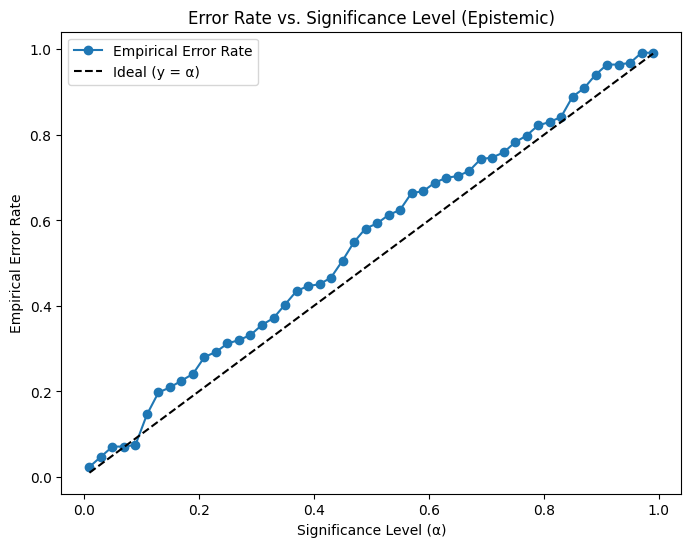

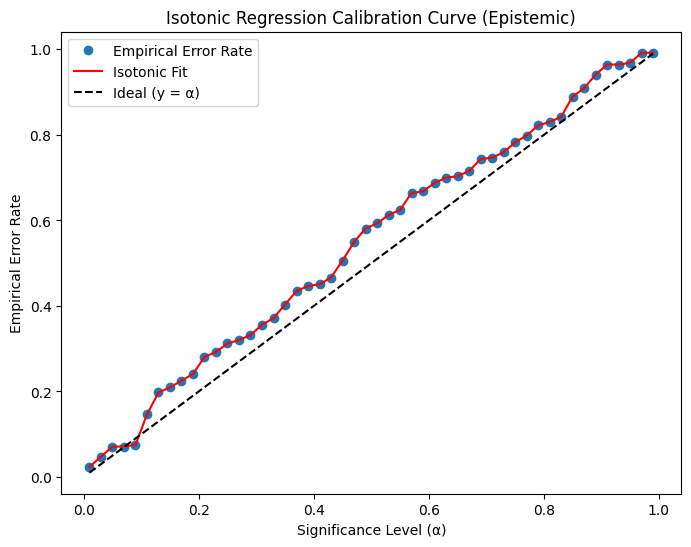

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

# --- Assumptions ---
# rf_cal_epi: a RandomForestRegressor trained on a calibration split from the KNN-imputed training data.
# X_cal_epi, y_cal_epi: calibration set (from KNN-imputed data) features and targets.
# X_test_knn, y_test_epi: test set (KNN-imputed) features and targets.
# (These variables were defined earlier in Notebook 2.)

# Compute calibration residuals for the epistemic model
y_cal_pred_epi = rf_cal_epi.predict(X_cal_epi)
residuals_cal_epi = np.abs(y_cal_epi - y_cal_pred_epi)

# Define a grid of significance levels (alpha)
alpha_grid_epi = np.linspace(0.01, 0.99, 50)
empirical_error_rates_epi = []

# Get test set predictions using the epistemic calibration model
y_test_pred_epi = rf_cal_epi.predict(X_test_knn)

for alpha in alpha_grid_epi:
    q_alpha_epi = np.quantile(residuals_cal_epi, 1 - alpha)
    coverage_epi = np.mean(np.abs(y_test_epi - y_test_pred_epi) <= q_alpha_epi)
    empirical_error_epi = 1 - coverage_epi
    empirical_error_rates_epi.append(empirical_error_epi)

# Plot the error rate vs. significance level for the epistemic model
plt.figure(figsize=(8,6))
plt.plot(alpha_grid_epi, empirical_error_rates_epi, 'o-', label="Empirical Error Rate")
plt.plot(alpha_grid_epi, alpha_grid_epi, 'k--', label="Ideal (y = α)")
plt.xlabel("Significance Level (α)")
plt.ylabel("Empirical Error Rate")
plt.title("Error Rate vs. Significance Level (Epistemic)")
plt.legend()
plt.show()

# --- Isotonic Regression Calibration for Epistemic Model ---
ir_epi = IsotonicRegression(out_of_bounds='clip')
ir_epi.fit(alpha_grid_epi, empirical_error_rates_epi)
alpha_fit_epi = np.linspace(0.01, 0.99, 50)
error_fit_epi = ir_epi.predict(alpha_fit_epi)

plt.figure(figsize=(8,6))
plt.plot(alpha_grid_epi, empirical_error_rates_epi, 'o', label="Empirical Error Rate")
plt.plot(alpha_fit_epi, error_fit_epi, 'r-', label="Isotonic Fit")
plt.plot(alpha_grid_epi, alpha_grid_epi, 'k--', label="Ideal (y = α)")
plt.xlabel("Significance Level (α)")
plt.ylabel("Empirical Error Rate")
plt.title("Isotonic Regression Calibration Curve (Epistemic)")
plt.legend()
plt.show()
